## Problem I - Backtests a strategy using three moving averages on any indices such as Nifty50, SPY, HSI and so on.

- Compute three moving averages of 20, 40, and 80.
- Go long when the price crosses above all three moving averages.
- Exit the long position when the price crosses below any of the three moving averages.
- Go short when the price crosses below all three moving averages.
- Exit the short position when the price crosses above any of the three moving averages.
- Optional: Optimize all three moving averages

In [48]:
import pandas as pd
import numpy as np
from datetime import datetime
import yfinance as yf
import matplotlib.pyplot as plt
import warnings
import cufflinks as cf
cf.go_offline()
warnings.filterwarnings('ignore')

In [49]:
from tvDatafeed import TvDatafeed, Interval
##########################################
username = ''
password = ''
##########################################
tv = TvDatafeed(username, password)

ERROR:tvDatafeed.main:error while signin


##
def download_data(stock, start, end):
    data = yf.download(stock, start, end, auto_adjust=True)
    data.index = pd.to_datetime(data.index)
    return data

In [50]:
# NIFTY INDEX.
Nifty_index_data = tv.get_hist(symbol='NIFTY',
                                    exchange='NSE',
                                    interval=Interval.in_1_hour,
                                    n_bars=20000)
Nifty_index_data =data= Nifty_index_data[['symbol','open','high','low','close','volume']]

In [51]:
def backtest_strategy(df, sma, mma, lma, print_chart):
    # Copy the data
    data = df.copy()
    
    # Create the moving averages
    data['sma'] = data['close'].rolling(window=sma).mean()
    data['mma'] = data['close'].rolling(window=mma).mean()
    data['lma'] = data['close'].rolling(window=lma).mean()
    
    # Create the signal column
    data['signal'] = np.nan
    
    # Set the length of the dataframe
    n = data.shape[0]
    
    # Loop through each day to compute the signal
    for i in range(1, n): 
        
        # Set the first day signal to zero
        if i == 1:
            data['signal'].iloc[i-1] = 0.0
            
        # Check if the three moving averages have non-Nan values
        if data[['sma','mma','lma']].iloc[i].isnull().values.any():
            data['signal'].iloc[i] = 0.0
            continue
        
        # Set the conditions per each moving average
        cond_sma = data['close'].iloc[i] >= data['sma'].iloc[i]
        cond_mma = data['close'].iloc[i] >= data['mma'].iloc[i]
        cond_lma = data['close'].iloc[i] >= data['lma'].iloc[i]

        # Check if we have no position in the asset
        if (data['signal'].iloc[i-1] == np.nan) | (data['signal'].iloc[i-1] == 0.0):

            # Check if we need to go long for today
            if cond_sma & cond_mma & cond_lma:
                data['signal'].iloc[i] = 1.0

            # Check if we need to go short for today
            elif (cond_sma==False) & (cond_mma==False) & (cond_lma==False):
                data['signal'].iloc[i] = -1.0
            else:
                data['signal'].iloc[i] = 0.0

        # Check if we are long for today
        elif data['signal'].iloc[i-1] == 1.0:
            # Check if we need to close our long position

            if (cond_sma==False) | (cond_mma==False) | (cond_lma==False):
                data['signal'].iloc[i] = 0.0

            # Carry the long position for the next day
            else:
                data['signal'].iloc[i] = 1.0

        # Check if we are short for today
        elif data['signal'].iloc[i-1] == -1.0:
            
            # Check if we need to close our short position
            if cond_sma | cond_mma | cond_lma:
                data['signal'].iloc[i] = 0.0
            # Carry the short position for the next day
            else:
                data['signal'].iloc[i] = -1.0

    # Print in case it's needed
    if print_chart == True:
        data[['signal', 'sma', 'mma', 'lma', 'close']].iplot(secondary_y='signal')

    # Compute the strategy returns
    data['strategy_returns'] = data['pct_returns'] * data['signal'].shift(1)

    return data

In [52]:
def generate_returns(stock):
    data['pct_returns'] = data['close'].pct_change()
    return data

In [53]:
def calculate_returns(data):
    bnh = (data['pct_returns']+1).cumprod()[-1]
    s_returns = (data['strategy_returns']+1).cumprod()[-1]
    return bnh, s_returns

In [54]:
#data = download_data('^NSEI', '2001-1-01', '2020-12-31')
data = generate_returns(data)
data = backtest_strategy(data,20, 70, 115, True)

bnh, s_returns = calculate_returns(data)

print('Buy and hold returns:', np.round(bnh, 2))
print('Strategy returns:', np.round(s_returns, 2))

Buy and hold returns: 1.42
Strategy returns: 2.04


Start date,2020-01-01
End date,2023-02-28
Total months,262
,Backtest
Annual return,3.315%
Cumulative returns,103.867%
Annual volatility,7.126%
Sharpe ratio,0.49
Calmar ratio,0.21
Stability,0.91
Max drawdown,-15.713%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,15.71,2020-03-13,2020-03-13,2020-11-06,171
1,12.92,2021-02-22,2021-04-26,2022-01-24,240
2,7.79,2022-01-27,2022-02-21,2022-04-01,47
3,5.73,2022-08-18,2022-10-14,2022-11-29,73
4,5.40,2022-06-17,2022-07-04,2022-07-22,25


Stress Events,mean,min,max
New Normal,0.01%,-11.75%,11.17%


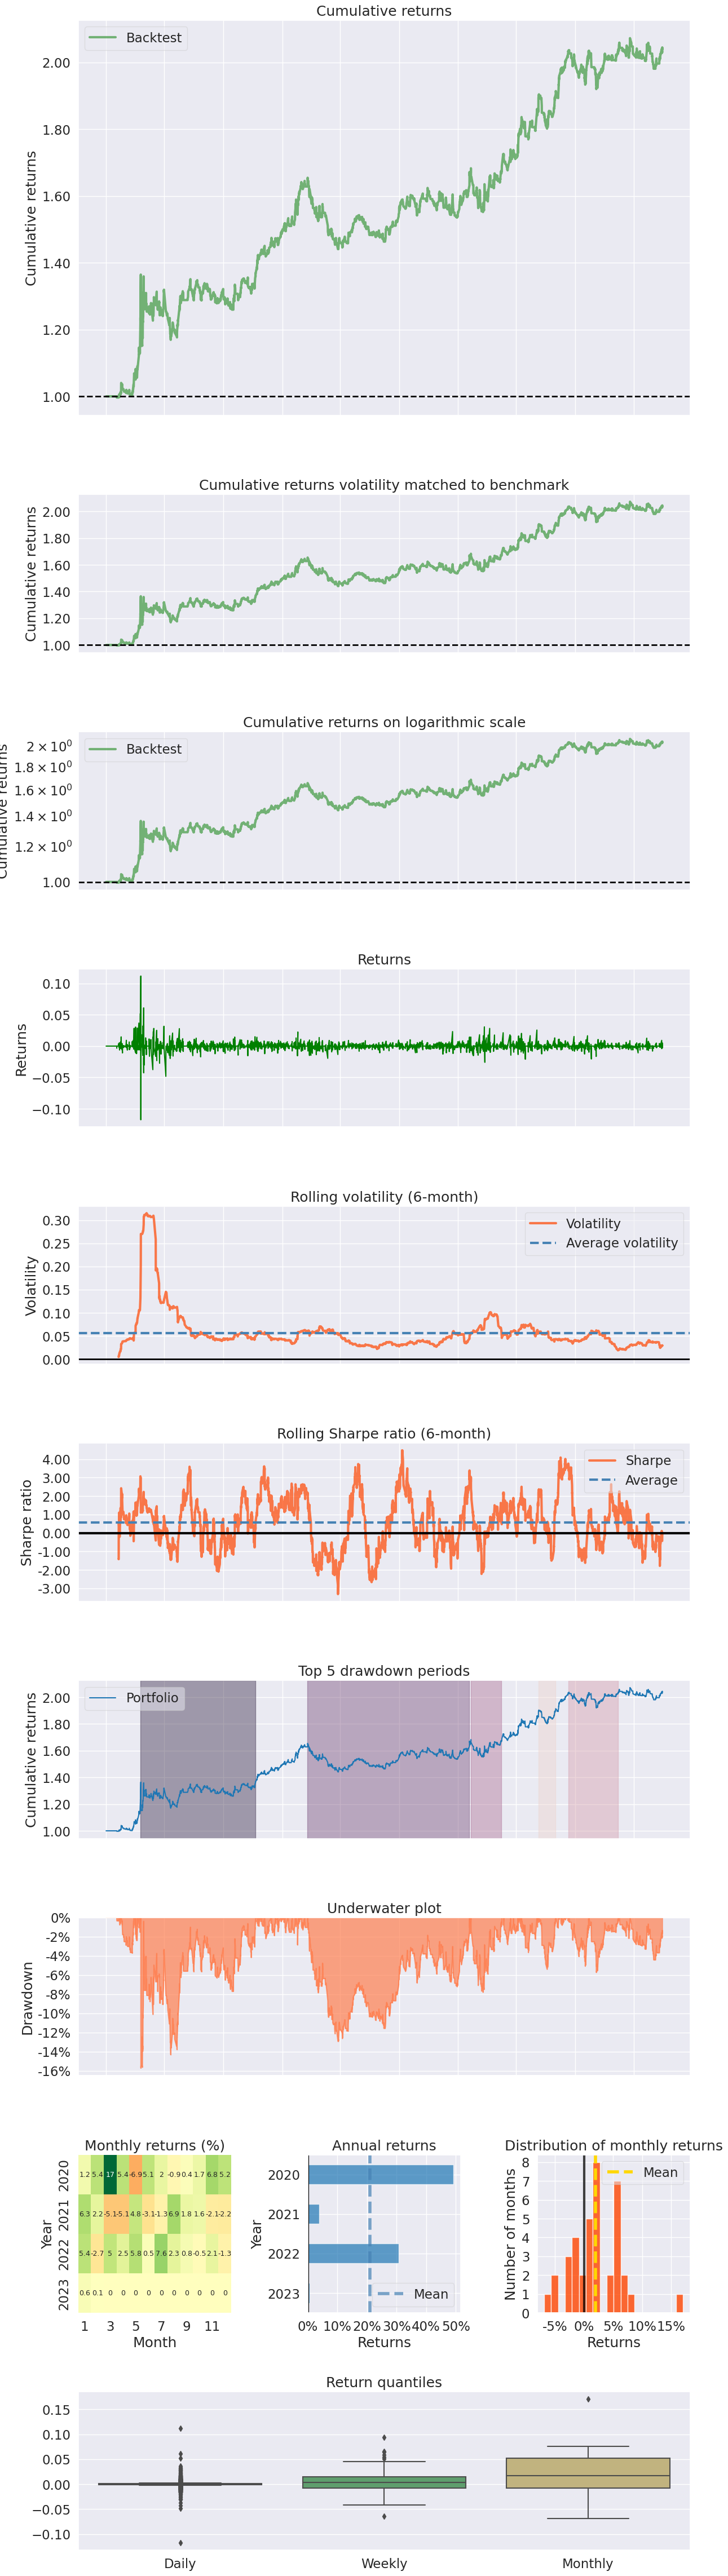

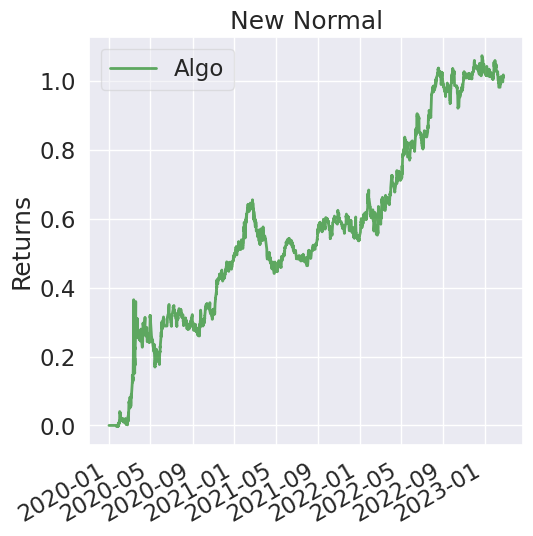

In [55]:
# Get the summary statistics for the strategy using pyfolio
import pyfolio as pf
pf.create_full_tear_sheet(data['strategy_returns'])

In [56]:
data['signall'] = np.where((data['signal'].shift(1)==0) & (data['signal'] == 1),1,0)
data['signall'] = np.where((data['signal'].shift(1)==0) & (data['signal'] == -1),-1,data['signall'])

In [57]:
data['signall'].value_counts()

 0    5169
 1     188
-1     147
Name: signall, dtype: int64

In [58]:
data['strategy_returns'].cumsum()[-1]

0.767827499185856

# data = download_data('^NSEI', '2015-1-1', '2020-12-31')
data = data
ma_dict = {}

# Optimize the strategy
for sma in range(15, 50, 5):
    for mma in range(60, 75, 5):
        for lma in range( 90,130, 5):
            key = 'sma'+str(sma)+'_mma'+str(mma)+'_lma'+str(lma)
            print(f'\nChecking for SMA: {sma}, MMA: {mma}, LMA: {lma}')
            df = data.copy()
            df = data = generate_returns(df)
            df = backtest_strategy(df, sma, mma, lma, False)
            bnh, s_returns = calculate_returns(df)
            print('Buy and hold returns:', np.round(bnh, 2))
            print('Strategy returns:', np.round(s_returns, 2))
            ma_dict[key] = s_returns
else:
    print('Computation Completed.')

# Print the sma, mma, lma values that yield the max strategy returns
max_ret = max(ma_dict.values())
opt_values = [key for key, value in ma_dict.items() if value == max_ret]
print(f"The max strategy returns are {max_ret} for the values {opt_values}.")